In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.plot_settings import get_figsize, LINE_STYLES, DPI
import os
from SBL_algs.SBL_Fast import SBL_Fast_Vector
from utils.Process_sim_data import load_nearfield, transform_nearfield_to_vector, transform_vector_to_nearfield
from radiation.sphere_wave import abF_matrix_alt, F_matrix_alt, Fmnc, F_expansion, nm_expansion, inverse_nm_expansion
import importlib
from utils.plot import plot_Fcoefficient_magnitudes, plot3D, plot_abcoefficient_magnitudes, vec_MSE

In [ ]:
R = 0.2759
f = 2.4e9
k = 2*np.pi*f/(3e8)
filename = 'dipole_nearfield_spherical.txt'
Efield_ff = load_nearfield(filename, undersampling=7)
Efield_ff_vec = transform_nearfield_to_vector(Efield_ff)

In [3]:
N_modes = 25
print(f"Number of samples:{len(Efield_ff.phi)*len(Efield_ff.theta)}")
print(f"Number of modes:{2*N_modes**2 + 4*N_modes}")

Number of samples:1352
Number of modes:1350


/home/jonas/Dokumente/Uni/12_Semester/Project/Code/SBL_algs/SBL_Fast.py:188: RuntimeWarning: invalid value encountered in multiply
  self.alpha = np.inf * np.ones(self.D, dtype=complex)
/home/jonas/Dokumente/Uni/12_Semester/Project/Code/SBL_algs/SBL_Fast.py:240: RuntimeWarning: invalid value encountered in divide
  s = np.where(np.isinf(self.alpha), S, (self.alpha * S) / (self.alpha - S))
/home/jonas/Dokumente/Uni/12_Semester/Project/Code/SBL_algs/SBL_Fast.py:241: RuntimeWarning: invalid value encountered in divide
  q = np.where(np.isinf(self.alpha), Q, (self.alpha * Q) / (self.alpha - S))
/home/jonas/Dokumente/Uni/12_Semester/Project/Code/SBL_algs/SBL_Fast.py:240: RuntimeWarning: invalid value encountered in multiply
  s = np.where(np.isinf(self.alpha), S, (self.alpha * S) / (self.alpha - S))


Relative MSE: 0.021944398233695803
Relative MSE (r): 1.1498255937588513
Relative MSE (theta): 5.1288044123873256e-06
Relative MSE (phi): 1.0
Relative MSE: 0.02220029399359835
Relative MSE (r): 1.1252474143765911
Relative MSE (theta): 0.0007440862533725803
Relative MSE (phi): 1.0
Relative MSE: 0.5530968639924498
Relative MSE (r): 1.1982320615331472
Relative MSE (theta): 0.540545868530771
Relative MSE (phi): 10.14415951018671
Relative MSE: 0.14418289136322673
Relative MSE (r): 1.1412019540013258
Relative MSE (theta): 0.12478912209160725
Relative MSE (phi): 1.0
Relative MSE: 0.14486586091806555
Relative MSE (r): 1.0356918775738342
Relative MSE (theta): 0.07678719743780903
Relative MSE (phi): 0.055918626179713354
Relative MSE: 0.14558281254600433
Relative MSE (r): 1.0356591923140204
Relative MSE (theta): 0.07718375732718463
Relative MSE (phi): 0.056992074954355994


/home/jonas/Dokumente/Uni/12_Semester/Project/Code/SBL_algs/SBL_Fast.py:257: RuntimeWarning: invalid value encountered in log
  delta = np.abs(Q[i])**2 / S[i] - 1 + np.log(S[i]/np.abs(Q[i])**2)


Relative MSE: 4.849987518890022
Relative MSE (r): 1.0539229299768302
Relative MSE (theta): 0.5006613153952539
Relative MSE (phi): 8.688775065521842
Relative MSE: 16.1009172785728
Relative MSE (r): 1.0449412977239056
Relative MSE (theta): 0.9003524212111892
Relative MSE (phi): 29.797774603665385


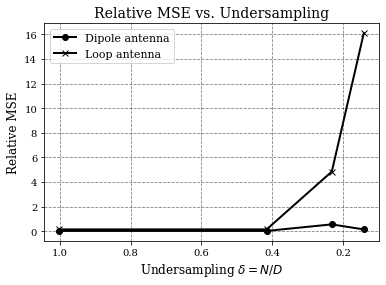

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.plot_settings import get_figsize, LINE_STYLES, DPI
import os
from SBL_algs.SBL_Fast import SBL_Fast_Vector
from utils.Process_sim_data import load_nearfield, transform_nearfield_to_vector, transform_vector_to_nearfield
from radiation.sphere_wave import abF_matrix_alt, F_matrix_alt, Fmnc, F_expansion, nm_expansion, inverse_nm_expansion
import importlib
from utils.plot import plot_Fcoefficient_magnitudes, plot3D, plot_abcoefficient_magnitudes, vec_MSE

R = 0.2759
f = 2.4e9
k = 2*np.pi*f/(3e8)
filename = 'dipole_farfield_spherical.txt'
N_modes = 25
D = 2*N_modes**2 + 4*N_modes

Efield_org = load_nearfield(filename, undersampling=7)
Efield_org_vec = transform_nearfield_to_vector(Efield_org)
F_org, nms_idx, _ = F_matrix_alt(Efield_org.theta, Efield_org.phi, R=R, N_modes=N_modes, k=k)

undersampling_range = range(7, 20, 4)
deltas_d = []
mses_d = []

for undersampling in undersampling_range:
    # Load and process farfield with current undersampling
    Efield_ff = load_nearfield(filename, undersampling=undersampling)
    Efield_ff_vec = transform_nearfield_to_vector(Efield_ff)
    N = len(Efield_ff.phi) * len(Efield_ff.theta)
    delta = N / D
    deltas_d.append(delta)
    
    # Forward matrix and SBL reconstruction
    F, nms_idx, _ = F_matrix_alt(Efield_ff.theta, Efield_ff.phi, R=R, N_modes=N_modes, k=k)
    sbl_vec_F = SBL_Fast_Vector(Efield_ff_vec, F, max_iter=100, threshold=1e-8)
    w_est_F, basis = sbl_vec_F.fit()
    
    # Reconstruct field
    Efield_SBLF_vec = np.zeros_like(Efield_org_vec)
    for i in range(3):
        Efield_SBLF_vec[:,i] = F_org[:,:,i] @ w_est_F
    # Compute relative MSE
    mse = vec_MSE(Efield_SBLF_vec, Efield_org_vec)
    mses_d.append(mse)


deltas_l = []
mses_l = []
filename = 'loop_farfield_spherical.txt'
Efield_org = load_nearfield(filename, undersampling=7)
Efield_org_vec = transform_nearfield_to_vector(Efield_org)
F_org, nms_idx, _ = F_matrix_alt(Efield_org.theta, Efield_org.phi, R=R, N_modes=N_modes, k=k)
for undersampling in undersampling_range:
    # Load and process farfield with current undersampling
    Efield_ff = load_nearfield(filename, undersampling=undersampling)
    Efield_ff_vec = transform_nearfield_to_vector(Efield_ff)
    N = len(Efield_ff.phi) * len(Efield_ff.theta)
    delta = N / D
    deltas_l.append(delta)
    
    # Forward matrix and SBL reconstruction
    F, nms_idx, _ = F_matrix_alt(Efield_ff.theta, Efield_ff.phi, R=R, N_modes=N_modes, k=k)
    sbl_vec_F = SBL_Fast_Vector(Efield_ff_vec, F, max_iter=100, threshold=1e-8)
    w_est_F, basis = sbl_vec_F.fit()
    
    # Reconstruct field
    Efield_SBLF_vec = np.zeros_like(Efield_org_vec)
    for i in range(3):
        Efield_SBLF_vec[:,i] = F_org[:,:,i] @ w_est_F
    # Compute relative MSE
    mse = vec_MSE(Efield_SBLF_vec, Efield_org_vec)
    mses_l.append(mse)

# Plotting
plt.figure()
plt.plot(deltas_d, mses_d, color='black', marker='o', label='Dipole antenna')
plt.plot(deltas_l, mses_l, color='black', marker='x', label='Loop antenna')
plt.xlabel('Undersampling $\\delta = N/D$')
plt.ylabel('Relative MSE')
plt.title('Relative MSE vs. Undersampling')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # Reverse x-axis
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.plot_settings import get_figsize, LINE_STYLES, DPI
import os
from SBL_algs.SBL_Fast import SBL_Fast_Vector
from utils.Process_sim_data import load_nearfield, transform_nearfield_to_vector, transform_vector_to_nearfield
from radiation.sphere_wave import abF_matrix_alt, F_matrix_alt, Fmnc, F_expansion, nm_expansion, inverse_nm_expansion
import importlib
from utils.plot import plot_Fcoefficient_magnitudes, plot3D, plot_abcoefficient_magnitudes, vec_MSE

R = 0.2759
f = 2.4e9
k = 2*np.pi*f/(3e8)
filename = 'dipole_farfield_spherical.txt'
N_modes = 25
D = 2*N_modes**2 + 4*N_modes

Efield_org = load_nearfield(filename, undersampling=7)
Efield_org_vec = transform_nearfield_to_vector(Efield_org)
F_org, nms_idx, _ = F_matrix_alt(Efield_org.theta, Efield_org.phi, R=R, N_modes=N_modes, k=k)

undersampling_range = range(7, 20, 4)
deltas_d = []
mses_d = []
filename = 'dipole_nearfield_spherical.txt'

for undersampling in undersampling_range:
    # Load and process farfield with current undersampling
    Efield_nf = load_nearfield(filename, undersampling=undersampling)
    Efield_nf_vec = transform_nearfield_to_vector(Efield_nf)
    N = len(Efield_nf.phi) * len(Efield_nf.theta)
    delta = N / D
    deltas_d.append(delta)
    
    # Forward matrix and SBL reconstruction
    F, nms_idx, _ = F_matrix_alt(Efield_nf.theta, Efield_nf.phi, R=R, N_modes=N_modes, k=k)
    sbl_vec_F = SBL_Fast_Vector(Efield_nf_vec, F, max_iter=100, threshold=1e-8)
    w_est_F, basis = sbl_vec_F.fit()
    
    # Reconstruct field
    Efield_SBLF_vec = np.zeros_like(Efield_org_vec)
    for i in range(3):
        Efield_SBLF_vec[:,i] = F_org[:,:,i] @ w_est_F
    # Compute relative MSE
    mse = vec_MSE(Efield_SBLF_vec, Efield_org_vec)
    mses_d.append(mse)


deltas_l = []
mses_l = []
filename = 'loop_farfield_spherical.txt'
Efield_org = load_nearfield(filename, undersampling=7)
Efield_org_vec = transform_nearfield_to_vector(Efield_org)
F_org, nms_idx, _ = F_matrix_alt(Efield_org.theta, Efield_org.phi, R=R, N_modes=N_modes, k=k)
filename = 'loop_nearfield_spherical.txt'

for undersampling in undersampling_range:
    # Load and process farfield with current undersampling
    Efield_nf = load_nearfield(filename, undersampling=undersampling)
    Efield_nf_vec = transform_nearfield_to_vector(Efield_nf)
    N = len(Efield_nf.phi) * len(Efield_nf.theta)
    delta = N / D
    deltas_l.append(delta)
    
    # Forward matrix and SBL reconstruction
    F, nms_idx, _ = F_matrix_alt(Efield_nf.theta, Efield_nf.phi, R=R, N_modes=N_modes, k=k)
    sbl_vec_F = SBL_Fast_Vector(Efield_nf_vec, F, max_iter=100, threshold=1e-8)
    w_est_F, basis = sbl_vec_F.fit()
    
    # Reconstruct field
    Efield_SBLF_vec = np.zeros_like(Efield_org_vec)
    for i in range(3):
        Efield_SBLF_vec[:,i] = F_org[:,:,i] @ w_est_F
    # Compute relative MSE
    mse = vec_MSE(Efield_SBLF_vec, Efield_org_vec)
    mses_l.append(mse)

# Plotting
plt.figure()
plt.plot(deltas_d, mses_d, color='black', marker='o', label='Dipole antenna')
plt.plot(deltas_l, mses_l, color='black', marker='x', label='Loop antenna')
plt.xlabel('Undersampling $\\delta = N/D$')
plt.ylabel('Relative MSE')
plt.title('Relative MSE vs. Undersampling')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # Reverse x-axis
plt.show()

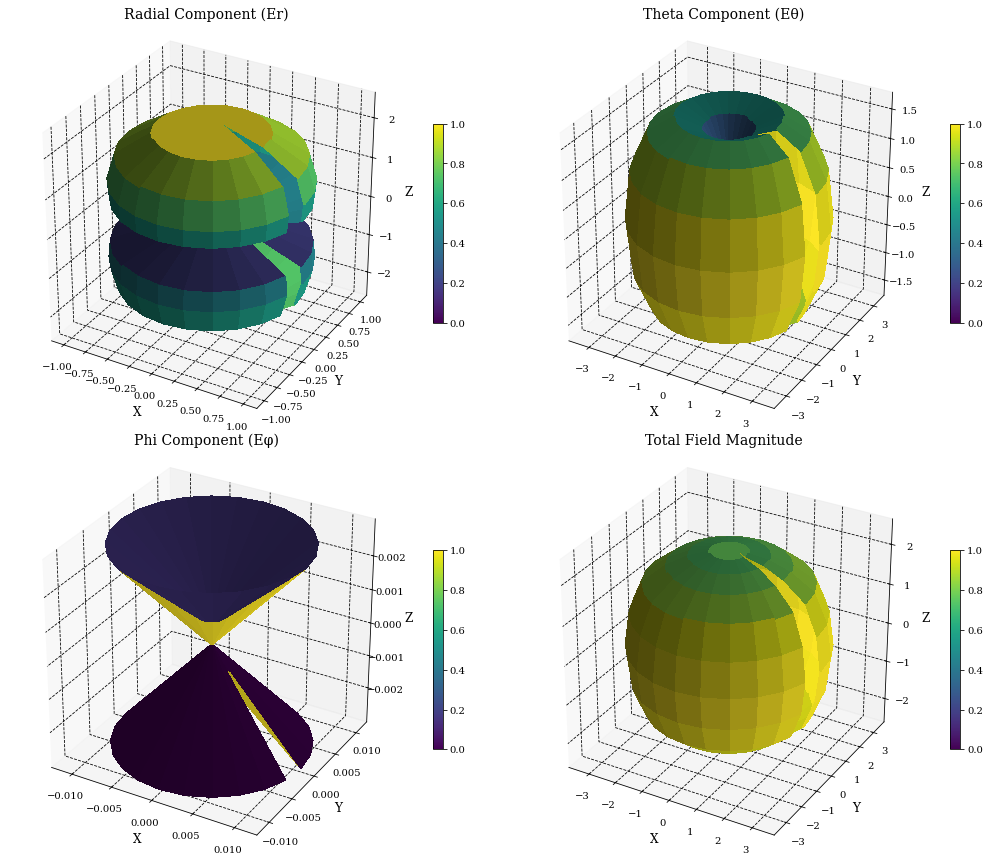

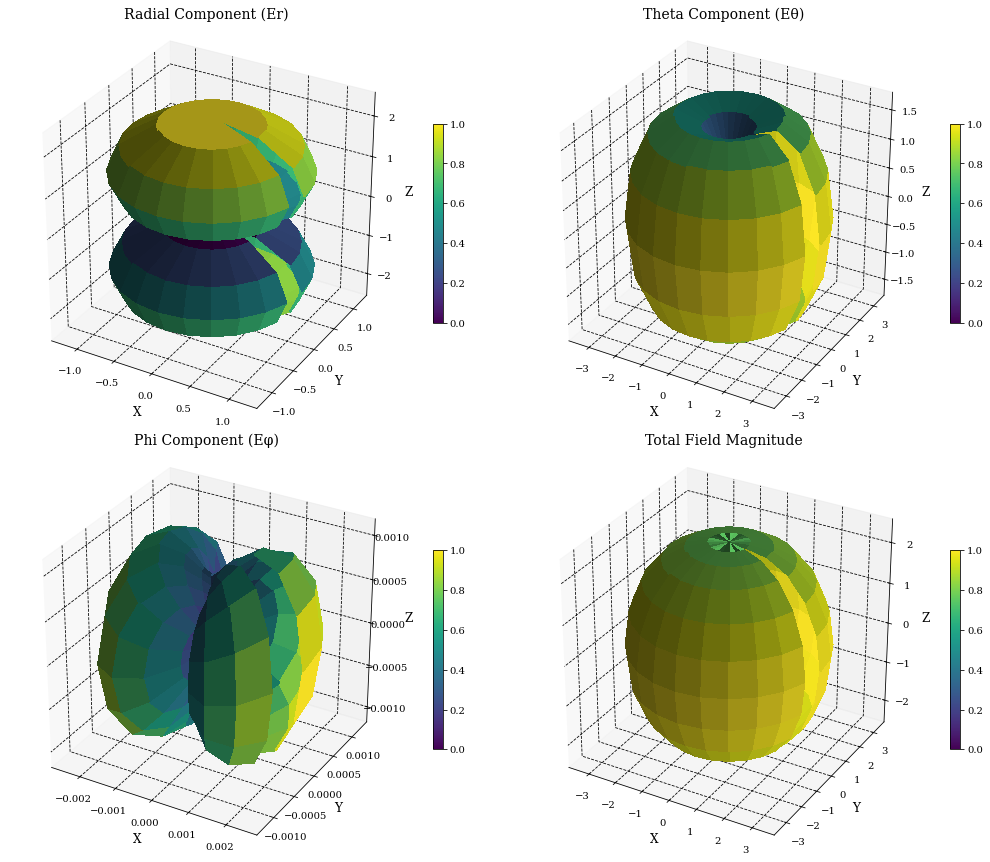

In [10]:
Efield_SBLF = transform_vector_to_nearfield(Efield_SBLF_vec, Efield_ff.theta, Efield_ff.phi)
plot3D(Efield_SBLF, Efield_SBLF.theta, Efield_SBLF.phi, R)
plot3D(Efield_ff, Efield_ff.theta, Efield_ff.phi, R)
